# 1. Projeção de mapas

**Fonte:**
este material é uma tradução e adaptação do notebook: <br/> https://github.com/Automating-GIS-processes/site/blob/master/source/notebooks/L2/projections.ipynb

Sistema de referência de coordenadas (CRS) são importantes, porque as geometrias utilizadas em GeoDataFrame são simplesmente uma coleção de coordenadas em um espaço arbitrário. O CRS diz ao python como essas coordenadas estão relacionadas com o espaço no planeta terra. Uma projeção de mapa é uma transformação sistemática de latitudes e longitudes em uma superficie plana, em que as unidades são comumente representadas em metros (em vez de graus). Esta transformação são usadas para representar a terra tridimensional em um mapa plano e bidimensional.

Como o CRS em diferentes conjuntos de dados espaciais diferem com frequência (isto é, pode-se ter coordenadas definidas em graus decimais enquanto em outro conjunto de dados está em metros), é um procedimento comum redefinir (ou reprojetar) o CRS para ser idêntico em ambos os datasets. É importante que as camadas possuam o mesmo sistema de referência de coordenadas, pois permite analisar as relações espaciais entre elas, como conduzir uma consulta de um Point em um Polygon.

Escolher uma projeção apropriada para o seu mapa nem sempre é  uma tarefa simples, porque depende do que você realmente quer representar com seu mapa e de qual é a escala espacial dos seus dados. De fato, não existe uma "projeção perfeita", já que cada uma tem alguns pontos fortes e fracos, e você deve escolher uma projeção que se ajuste melhor às suas necessidades. Na verdade, a projeção que você escolher pode até dizer algo sobre você:
    
![](images/Map-projections.png)
*Fonte: XKCD, See a full comic about ["What your favorite map projection tells about you"](https://xkcd.com/977/)*.

Para aqueles que querem um pouco mais de abordagem analítica para escolher a projeção, você pode obter uma boa visão geral em [georeference.org](http://www.georeference.org/doc/guide_to_selecting_map_projections.htm), ou neste post introduzindo [os pontos fortes e fracos de algumas projeções comumente usadas](http://usersguidetotheuniverse.com/index.php/2011/03/03/whats-the-best-map-projection/).

## 1.1 Sistema de Referência de Coordenadas (SRC) no Geopandas

Para este tutorial, usaremos o Shapefile chamado `limitebairro.shp` que possui as fronteiras de cada bairros na cidade de Fortaleza/CE.

O Shapefile deve sempre conter informações sobre o sistema de referência de coordenadas que é armazenado no arquivo `.prj` (se os dados tiverem sido produzidos corretamente). Ao ler os dados em `GeoDataFrame` com Geopandas esta informação é automaticamente armazenada no atributo `.crs` do GeoDataFrame.

- Vamos começar lendo os dados do arquivo `limitebairro.shp` e verificando o` crs`:

In [2]:
# Import necessary packages
import geopandas as gpd

# Read the file
fp = "data/limitebairro.shp"
data = gpd.read_file(fp)

# Check the coordinate reference system
data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Como podemos ver, o `crs` é um conjunto de informações que identificam a projeção utilizada, neste caso podemos identificaro o código `EPSG:4326`. Essa é uma maneira muito típica de como o CRS é armazenado em GeoDataFrames. Há também outra maneira típica de representar o sistema de referência de coordenadas, ou seja, armazenar essa informação no formato [Proj4-string](https://proj4.org/usage/quickstart.html).

O número da sigla __EPSG__ ("European Petroleum Survey Group") é um código que informa sobre o sistema de coordenadas do conjunto de dados. [Conjunto de dados de parâmetros geodésicos EPSG](http://www.epsg.org/) é uma coleção de definições de sistemas de referência de coordenadas e coordena transformações que podem ser globais, regionais, nacionais ou locais". O código EPSG `4326` que temos aqui, pertence ao sistema de coordenadas WGS84 (isto é, as coordenadas estão em graus decimais: latitudes e longitudes).

Você pode encontrar mais informações e listas de sistemas de referência de coordenadas em:

  - [www.spatialreference.org](http://spatialreference.org/)
  - [www.proj4.org](https://proj4.org/operations/projections/)
  - [www.mapref.org](http://mapref.org/CollectionofCRSinEurope.html)

- Vamos continuar verificando os valores na coluna `geometry` para verificar se o CRS de nosso GeoDataFrame parece correto:

In [3]:
data['geometry'].head()

0    POLYGON ((-38.53982 -3.79554, -38.53974 -3.795...
1    POLYGON ((-38.47933 -3.72091, -38.47930 -3.720...
2    POLYGON ((-38.46765 -3.74968, -38.46751 -3.749...
3    POLYGON ((-38.51716 -3.76998, -38.51726 -3.769...
4    POLYGON ((-38.56888 -3.70169, -38.56893 -3.701...
Name: geometry, dtype: geometry

Como podemos observar, os valores de coordenadas dos polígonos realmente se parecem com valores de latitude e longitude, então tudo parece estar em ordem.

## 1.2 Calculando a área em metros

Vamos chamar a função `area` para o nosso `GeoDataFrame` e analisar o resultado.

In [5]:
# Make a selection that contains only the first five rows
selection = data[0:5]

# Iterate over rows and print the area of a Polygon
for index, row in selection.iterrows():
    # Get the area of the polygon
    poly_area = row['geometry'].area
    # Get the name att of the polygon
    poly_name = row['NOME']
    # Print information for the user
    print("Bairro {name} possui uma área de {area:.5f} graus quadrados".format(name=poly_name, 
                                                                                area=poly_area))

Bairro PASSARE possui uma área de 0.00058 graus quadrados
Bairro CAIS DO PORTO possui uma área de 0.00021 graus quadrados
Bairro CIDADE 2000 possui uma área de 0.00004 graus quadrados
Bairro ALTO DA BALANCA possui uma área de 0.00007 graus quadrados
Bairro BARRA DO CEARA possui uma área de 0.00033 graus quadrados


Como podemos observar, obtemos valores baixos, considerando que estamos calculando a área de grandes aglomerados urbanos. Isso acontece, porque os nosso dados estão em um sistema de coordenadas geográfica, desta forma, os nosso valores estão representados em graus. A função de cálculo da área não se importa em qual projeção os dados estão, ela apenas cálcula a área de cada geometria do nosso `GeoDataFrame`.

Felizmente, para definir e alterar projeções no Geopandas é fácil. Agora vamos reprojetar os dados de
WGS84 (coordenadas de latitude longitude) em uma projeção planar, facilitando o cálculo das métricas em metros. No nosso exemplo, iremos utilizar a projeção padrão para américa do sul [SIRGAS 2000](http://www.sirgas.org/pt/sirgas-realizations/sirgas2000/).

De acordo com os dados de datum (SIRGAS 2000), projeção (UTM), fuso horário (24) e o hemisfério (Sul), o código para a cidade de Fortaleza é o EPSG:31984 

In [6]:
epsg_proj = "EPSG:31984"

In [7]:
# Reproject the data
data_proj = data.to_crs(epsg_proj)

# Check the new geometry values
print(data_proj['geometry'].head())

0    POLYGON ((551095.599 9580459.369, 551104.542 9...
1    POLYGON ((557816.513 9588704.498, 557820.203 9...
2    POLYGON ((559112.388 9585523.444, 559127.299 9...
3    POLYGON ((553612.653 9583283.104, 553602.293 9...
4    POLYGON ((547874.164 9590834.764, 547867.807 9...
Name: geometry, dtype: geometry


Podemos ver que os valores de coordenadas nas geometrias foram alterados! Agora, mudamos com sucesso a projeção de nossa camada para uma nova.

Vamos novamente chamar a função area para o nosso GeoDataFrame e analisar o resultado.

In [8]:
# Reproject the data
data_proj = data.to_crs(epsg_proj)

# Make a selection that contains only the first five rows
selection = data_proj[0:5]

# Iterate over rows and print the area of a Polygon
for index, row in selection.iterrows():
    # Get the area of the polygon
    poly_area = row['geometry'].area
    # Get the name att of the polygon
    poly_name = row['NOME']
    # Print information for the user
    print("Bairro {name} possui uma área de {area:.5f} metros quadrados".format(name=poly_name, 
                                                                                area=poly_area))

Bairro PASSARE possui uma área de 7167306.64176 metros quadrados
Bairro CAIS DO PORTO possui uma área de 2562799.52426 metros quadrados
Bairro CIDADE 2000 possui uma área de 497197.33551 metros quadrados
Bairro ALTO DA BALANCA possui uma área de 916449.73840 metros quadrados
Bairro BARRA DO CEARA possui uma área de 4102986.76628 metros quadrados


Agora temos os valores de área em m². Podemos transformar de m² para km² dividindo por 1000000.

In [9]:
# Reproject the data
data_proj = data.to_crs(epsg_proj)

# Make a selection that contains only the first five rows
selection = data_proj[0:5]

# Iterate over rows and print the area of a Polygon
for index, row in selection.iterrows():
    # Get the area of the polygon
    poly_area = row['geometry'].area / 1000000
    # Get the name att of the polygon
    poly_name = row['NOME']
    # Print information for the user
    print("Bairro {name} possui uma área de {area:.5f} quilômetros quadrados".format(name=poly_name, 
                                                                                area=poly_area))

Bairro PASSARE possui uma área de 7.16731 quilômetros quadrados
Bairro CAIS DO PORTO possui uma área de 2.56280 quilômetros quadrados
Bairro CIDADE 2000 possui uma área de 0.49720 quilômetros quadrados
Bairro ALTO DA BALANCA possui uma área de 0.91645 quilômetros quadrados
Bairro BARRA DO CEARA possui uma área de 4.10299 quilômetros quadrados


Vamos salvar nossos dados projetados em um Shapefile para podermos usar mais tarde.

In [10]:
# Ouput filepath
outfp = "data/limitebairro_proj.shp"
    
# Save to disk
data_proj.to_file(outfp)

## 1.3 Calculando a distância em metros

Em seguida, conduziremos um exemplo prático com o arquivo `limitebairro_proj.shp`. Nosso objetivo é encontrar as distâncias euclidianas dos centróides (pontos médios) de todos os bairros de Fortaleza para a nossa geometria do Campus do Pici.

Vamos primeiro criar um GeoDataFrame que contenha um polígono representando a localização do Campus do Pici.

In [11]:
from shapely.geometry import Polygon

# Approximate coordinates of Campus do Pici, UFC (Fortaleza/CE)
coordinates = [(-38.57351, -3.73745), (-38.58482, -3.74404), (-38.58471, -3.74632), (-38.58146, -3.74620),
               (-38.58200, -3.74711), (-38.57242, -3.75738), (-38.57186, -3.75680), (-38.57256, -3.75608),
               (-38.57090, -3.75490), (-38.57079, -3.75400), (-38.57464, -3.74978), (-38.57122, -3.74648),
               (-38.56920, -3.74857), (-38.56670, -3.74600), (-38.56938, -3.74132), (-38.56933, -3.73688)]

# Create a Shapely polygon from the coordinate-tuple list
poly = Polygon(coordinates)

# Create an empty geopandas GeoDataFrame
gdf_pici = gpd.GeoDataFrame([poly], geometry='geometry', 
                            crs='EPSG:4326', 
                            columns=['geometry'])

gdf_pici.loc[0, 'location'] = 'Campus do Pici'

# # Let's see what we have
print(gdf_pici)

                                            geometry        location
0  POLYGON ((-38.57351 -3.73745, -38.58482 -3.744...  Campus do Pici


Para instalar o módulo pycrs, você pode utilizar o seguinte comando: conda install -c conda-forge pycrs 

Como podemos ver, é possível criar um GeoDataFrame diretamente utilizando penas uma linha de código. Observe que, aqui, especificamos o CRS diretamente passando o crs como a string "EPSG:4326". Nós também dissemos que a informação `geometry` é armazenada na coluna `geometry` que nós definimos com o parâmetro `columns = ['geometry'] `.

Em seguida, precisamos converter essa projeção do `GeoDataFrame` para a projeção do SIRGAS 2000.

In [12]:
epsg_proj = "EPSG:31984"

gdf_pici_proj = gdf_pici.to_crs(epsg_proj)

# Print the data
print(gdf_pici_proj)

# Print the crs
print('\nCRS:\n', gdf_pici_proj.crs)

                                            geometry        location
0  POLYGON ((547357.837 9586882.111, 546101.598 9...  Campus do Pici

CRS:
 EPSG:31984


Vamos ler novamente todos os bairros e mudar para a projeção SIRGAS 2000.

In [13]:
# Set filepath 
fp = "data/limitebairro.json"
epsg_proj = "EPSG:31984"

# Read file using gpd.read_file()
gdf_bairros = gpd.read_file(fp, driver='GeoJSON')
gdf_bairros_proj = gdf_bairros.to_crs(epsg_proj)

# Print the data
print(gdf_bairros_proj.head())

# Print the crs
print('\nCRS:\n', gdf_bairros_proj.crs)

                                            id  GID             NOME  \
0  Limite Bairro.fid-2be50750_153af4824fe_2d2e    6          PASSARE   
1  Limite Bairro.fid-2be50750_153af4824fe_2d2f   21    CAIS DO PORTO   
2  Limite Bairro.fid-2be50750_153af4824fe_2d30   22      CIDADE 2000   
3  Limite Bairro.fid-2be50750_153af4824fe_2d31   23  ALTO DA BALANCA   
4  Limite Bairro.fid-2be50750_153af4824fe_2d32   17   BARRA DO CEARA   

                                            geometry  
0  POLYGON ((551095.599 9580459.369, 551104.542 9...  
1  POLYGON ((557816.513 9588704.498, 557820.203 9...  
2  POLYGON ((559112.388 9585523.444, 559127.299 9...  
3  POLYGON ((553612.653 9583283.104, 553602.293 9...  
4  POLYGON ((547874.164 9590834.764, 547867.807 9...  

CRS:
 EPSG:31984


Agora podemos ver que as coordenadas na coluna `geometry` são números bastante grandes, pois representam a distância em metros de acordo com um ponto de referência, diferente ds medidas de graus utilizadas anteriormente.

- Vamos traçar as fronteiras dos bairros de Fortaleza e a localização do Campus do Pici para observar se as mudanças de projeção estão conforme o esperado.

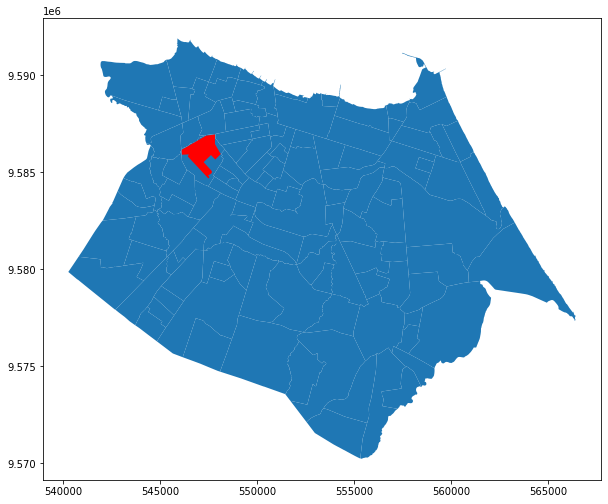

In [14]:
import matplotlib.pyplot as plt

%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

# Plot the country borders
gdf_bairros_proj.plot(ax=ax)

# Plot the Helsinki point on top of the borders using the same axis
gdf_pici_proj.plot(ax=ax, color='red', markersize=30)

Como podemos ver no mapa, os dois dados aparentam estar na mesma projeção.

Em seguida, nosso objetivo é calcular a distância de todos os bairros até o Campus do Pici. Para podermos fazer isso, precisamos calcular os centróides de todos os polígonos que representam os limites dos bairros fortalezenses.

- Isso pode ser feito facilmente em Geopandas usando o atributo `centroid`:

In [15]:
gdf_bairros_proj['centroid'] = gdf_bairros_proj.centroid
gdf_bairros_proj.head(3)

,id,GID,NOME,geometry,centroid
0,Limite Bairro.fid-2be50750_153af4824fe_2d2e,6,PASSARE,"POLYGON ((551095.599 9580459.369, 551104.542 9...",POINT (551957.460 9578515.003)
1,Limite Bairro.fid-2be50750_153af4824fe_2d2f,21,CAIS DO PORTO,"POLYGON ((557816.513 9588704.498, 557820.203 9...",POINT (558784.923 9589362.498)
2,Limite Bairro.fid-2be50750_153af4824fe_2d30,22,CIDADE 2000,"POLYGON ((559112.388 9585523.444, 559127.299 9...",POINT (558640.923 9585360.684)


Agora nós criamos uma nova coluna chamada `centroid` que possui as geometrias de Ponto representando os centróides de cada polígono (na projeção SIRGAS 2000).

Em seguida, calcularemos as distâncias entre os bairros até o centroid do Campus do Pici. Para fazer isso, poderíamos usar a função `iterrows ()` que usamos anteriormente, mas aqui demonstraremos uma técnica mais eficiente (mais rápida) para percorrer todas as linhas no GeoDataFrame usando a função `apply()`.

A função [apply()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) pode dar um grande impulso no desempenho sobre o `iterrows()` e é a maneira recomendável de iterar as linhas em GeoDataFrames. Aqui, veremos como usá-la para calcular a distância entre os centróides dos bairros até o centroid do Campus do Pici.

- Antes de usar nossa função e calcular as distâncias entre o Campus do Pici e os centróides, precisamos obter a geometria do ponto Shapely do ponto central do Campus do Pici reprojetado, para que passamos passar para a nossa função (no parâmetro `dest_geom`. Podemos usar a função `loc` para recuperar o valores especificos de índice e coluna:

In [16]:
# Retrieve the geometry from Campus do Pici GeoDataFrame
pici_centroid = gdf_pici_proj.loc[0, 'geometry'].centroid
print(pici_centroid)

POINT (547179.711048448 9586001.998799218)


Agora vamos calcular todas as distâncias com apply.

In [17]:
gdf_bairros_proj['dist_to_pici'] = gdf_bairros_proj.apply(lambda row: row.centroid.distance(pici_centroid), axis=1)

In [18]:
gdf_bairros_proj.head(3)

,id,GID,NOME,geometry,centroid,dist_to_pici
0,Limite Bairro.fid-2be50750_153af4824fe_2d2e,6,PASSARE,"POLYGON ((551095.599 9580459.369, 551104.542 9...",POINT (551957.460 9578515.003),8881.553556
1,Limite Bairro.fid-2be50750_153af4824fe_2d2f,21,CAIS DO PORTO,"POLYGON ((557816.513 9588704.498, 557820.203 9...",POINT (558784.923 9589362.498),12081.965887
2,Limite Bairro.fid-2be50750_153af4824fe_2d30,22,CIDADE 2000,"POLYGON ((559112.388 9585523.444, 559127.299 9...",POINT (558640.923 9585360.684),11479.140445


Também podemos transformar as nossas distâncias de metros para quilômetros.

In [19]:
gdf_bairros_proj['dist_to_pici'] = gdf_bairros_proj['dist_to_pici'] / 1000

In [20]:
gdf_bairros_proj.head(3)

,id,GID,NOME,geometry,centroid,dist_to_pici
0,Limite Bairro.fid-2be50750_153af4824fe_2d2e,6,PASSARE,"POLYGON ((551095.599 9580459.369, 551104.542 9...",POINT (551957.460 9578515.003),8.881554
1,Limite Bairro.fid-2be50750_153af4824fe_2d2f,21,CAIS DO PORTO,"POLYGON ((557816.513 9588704.498, 557820.203 9...",POINT (558784.923 9589362.498),12.081966
2,Limite Bairro.fid-2be50750_153af4824fe_2d30,22,CIDADE 2000,"POLYGON ((559112.388 9585523.444, 559127.299 9...",POINT (558640.923 9585360.684),11.479140


Ótimo! Agora calculamos com sucesso as distâncias entre os centróides de cada bairro em formato de Polygon para o centroid do Campus do Pici em formato de Point. 😎

- Vamos verificar qual é a distância mais longa e a distância média para o Campus do Pici, em relação aos centróides dos outros bairros de fortaleza:

In [21]:
# Calculat the maximum and average distance
max_dist = gdf_bairros_proj['dist_to_pici'].max()
mean_dist = gdf_bairros_proj['dist_to_pici'].mean()

print("Maximum distance to Campus do Pici is %.0f km, and the mean distance is %.0f km." % (max_dist, mean_dist))

Maximum distance to Campus do Pici is 17 km, and the mean distance is 7 km.


Vamos ver em ordem crescente de distância, quais os bairros mais próximos com relação ao centróide.

In [22]:
gdf_bairros_proj.sort_values('dist_to_pici', ascending=True)

,id,GID,NOME,geometry,centroid,dist_to_pici
105,Limite Bairro.fid-2be50750_153af4824fe_2d97,102,PICI,"POLYGON ((548056.004 9585341.580, 548049.228 9...",POINT (547217.418 9585706.867),0.297531
99,Limite Bairro.fid-2be50750_153af4824fe_2d91,92,PADRE ANDRADE,"POLYGON ((546128.979 9587527.481, 546150.139 9...",POINT (546572.934 9587052.535),1.213180
58,Limite Bairro.fid-2be50750_153af4824fe_2d68,49,PANAMERICANO,"POLYGON ((547790.757 9584777.621, 547726.477 9...",POINT (548277.125 9584854.883),1.587511
115,Limite Bairro.fid-2be50750_153af4824fe_2da1,110,DOM LUSTOSA,"POLYGON ((546349.250 9585139.782, 546352.710 9...",POINT (545758.666 9585135.024),1.664637
110,Limite Bairro.fid-2be50750_153af4824fe_2d9c,106,PRESIDENTE KENNEDY,"POLYGON ((546947.172 9587888.345, 546952.753 9...",POINT (547724.419 9587647.532),1.733345
...,...,...,...,...,...,...
50,Limite Bairro.fid-2be50750_153af4824fe_2d60,40,LAGOA REDONDA,"POLYGON ((559116.378 9574901.995, 559037.988 9...",POINT (560043.184 9577159.094),15.609801
8,Limite Bairro.fid-2be50750_153af4824fe_2d36,28,PAUPINA,"POLYGON ((557111.551 9572820.818, 557238.674 9...",POINT (556386.334 9573261.990),15.718452
7,Limite Bairro.fid-2be50750_153af4824fe_2d35,26,PEDRAS,"POLYGON ((555310.209 9570240.217, 555309.000 9...",POINT (554245.568 9571661.421),15.986823
34,Limite Bairro.fid-2be50750_153af4824fe_2d50,11,SAO BENTO,"POLYGON ((557238.674 9572798.279, 557111.551 9...",POINT (557477.064 9573725.019),16.023723


Aviso: se você quiser calcular distâncias entre vários locais ao redor do mundo, é recomendável usar a [fórmula de Haversine](https://en.wikipedia.org/wiki/Haversine_formula) para fazer os cálculos. O pacote [Haversine](https://github.com/mapado/haversine) em Python fornece uma função fácil de usar para calcular com base em valores de latitude e longitude.

## Resumo 

Durante este tutorial, vimos como:

**1)** Definir o sistema de referência de coordenadas utilizando o código EPSG; <br/>
**2)** Reprojetar (transformar) as geometrias de um CRS para outro usando a função `to_crs ()` no GeoPandas; <br/>
**3)** Calcular as distâncias entre os locais e usar a função `apply()` para iterar as linhas de maneira mais eficiente do que usando o `iterrows()`. 